In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud

In [16]:
# 1. Synthetic Training Data Generation
np.random.seed(42)

num_samples = 1000  # Fixed dataset for training

data = {
    'reviewerID': np.arange(1, num_samples + 1),
    'asin': np.random.choice(['Guitar', 'Piano', 'Violin', 'Drums', 'Flute'], num_samples),
    'reviewerName': [f"User_{i}" for i in range(1, num_samples + 1)],
    'helpful': np.random.randint(0, 20, num_samples),
    'reviewText': np.random.choice([
        "Amazing sound quality, highly recommend!",
        "Not worth the money, poor durability.",
        "Great for beginners, but not professional use.",
        "Absolutely love it, perfect instrument!",
        "Disappointed with the build quality."
    ], num_samples),
    'overall': np.random.randint(1, 6, num_samples),  # Ratings from 1 to 5
    'summary': np.random.choice([
        "Best purchase!", "Not good", "Good for price", "Excellent!", "Terrible quality"
    ], num_samples),
    'unixReviewTime': np.random.randint(1609459200, 1672531199, num_samples)  # Random timestamps
}

df = pd.DataFrame(data)

In [17]:
# 2. Data Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['reviewText'] = df['reviewText'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

# Convert categorical 'asin' to numerical encoding
df['asin'] = LabelEncoder().fit_transform(df['asin'])

# Scale numerical features
scaler = StandardScaler()
df['helpful'] = scaler.fit_transform(df[['helpful']])

In [18]:
# 3. Feature Engineering (TF-IDF for Review Text)
vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(df['reviewText']).toarray()
X_numeric = df[['asin', 'helpful', 'overall']].values
X = np.hstack((X_text, X_numeric))

# Target variable (Binary: Good (4-5) vs. Bad (1-3))
y = df['overall'] >= 4

In [19]:
# 4. Splitting Data (Using Synthetic Data for Training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# 5. Model Training (RandomForest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       113
        True       1.00      1.00      1.00        87

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.00


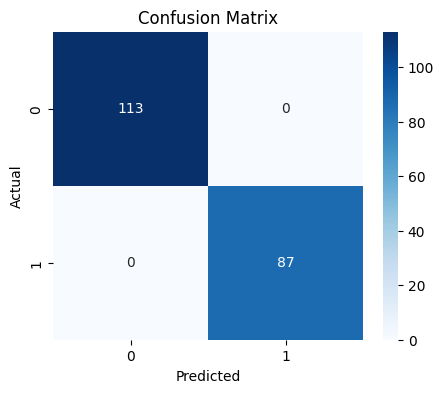

In [21]:
# 6. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

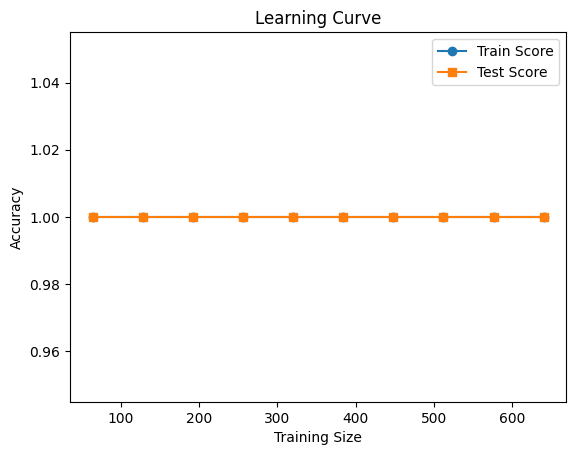

In [22]:
# 7. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Train Score')
plt.plot(train_sizes, test_mean, marker='s', label='Test Score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()